In [1]:
!git clone https://github.com/UCSD-AI4H/COVID-CT.git

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5463, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5463 (delta 0), reused 1 (delta 0), pack-reused 5459
Receiving objects: 100% (5463/5463), 1.09 GiB | 25.50 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Updating files: 100% (1048/1048), done.


In [ ]:
!unzip '/content/COVID-CTT/Images-processed/CT_COVID.zip' -d '/content/'

In [ ]:
!unzip '/content/COVID-CTT/Images-processed/CT_NonCOVID.zip' -d '/content/'

In [4]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

from tensorflow.keras.models import Model, load_model

In [58]:
# LR = 0.0001
EPOCHS = 500
BATCH_SIZE = 16
IMG_SIZE = 224

In [59]:

imagePaths = []

for dirname, _, filenames in os.walk('/content/COVID-CT/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [60]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


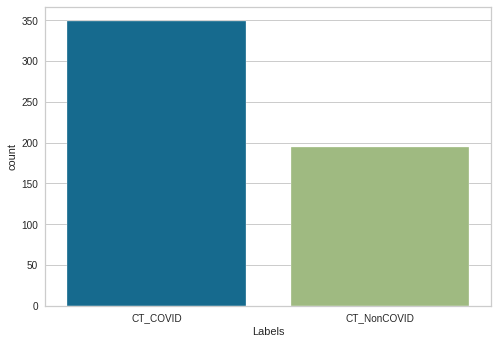

In [61]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [62]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [63]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [64]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(435, 224, 224, 3)
(435, 2)
(109, 224, 224, 3)
(109, 2)


In [65]:
# !pip install --user tensorflow-addons==0.8.3
# !pip install --user tensorflow==2.2.0-rc3

!pip install tensorflow-addons

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

!pip install --quiet vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
TensorFlow Version 2.11.0


In [66]:
from vit_keras import vit

In [67]:
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)


# # image_size = 224
# vit_model = vit.vit_l32(
#     image_size=224,
#     activation='softmax',
#     pretrained=True,
#     include_top=True,
#     pretrained_top=False,
#     classes=2
# )

In [68]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 11)                8459      
                                                                 
 batch_normalization_5 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 2)          

In [69]:
import time
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris

In [70]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 30,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

callbacks = [earlystopping, reduce_lr]
# callbacks = [reduce_lr]

In [71]:

# optim = Adam(lr = LR, decay = LR/EPOCHS)

learning_rate = 1e-4

# optimizer = tfa.optimizers.AdamW(learning_rate = learning_rate)

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

# optimizer = tfa.optimizers.AdamW(
#     learning_rate=1e-4,
#     weight_decay=1e-4
# )
# optimizer = opt

# model.compile(optimizer = optimizer, 
#               loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.2), 
#               metrics = ['accuracy'])


model.compile(optimizer = optimizer, 
              loss ='categorical_crossentropy', 
              metrics = ['accuracy'])

# start = time.time()
# # model.fit(X, y)
# stop = time.time()
# print(f"Training time: {stop - start}s")

import time
start = time.time()

# model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

# compile the model with precision, recall, and F1 score as metrics
# model.compile(optimizer=optim, loss='categorical_crossentropy', 
              # metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])



history = model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=500,
                                    callbacks = callbacks,
                                    verbose=1)
end = time.time()

print('Program processed ', end - start, 's, ', (end - start)/60, 'min, ', (end - start)/3600, 'h')

# stop = time.time()
# print(f"Training time: {stop - start}s")

Epoch 1/500
27/27 [==============================] - 55s 439ms/step - loss: 0.7813 - accuracy: 0.5585 - val_loss: 0.5638 - val_accuracy: 0.6972 - lr: 1.0000e-04
Epoch 2/500
27/27 [==============================] - 8s 307ms/step - loss: 0.5843 - accuracy: 0.7232 - val_loss: 0.4981 - val_accuracy: 0.7523 - lr: 1.0000e-04
Epoch 3/500
27/27 [==============================] - 8s 277ms/step - loss: 0.5017 - accuracy: 0.7446 - val_loss: 0.4624 - val_accuracy: 0.7706 - lr: 1.0000e-04
Epoch 4/500
27/27 [==============================] - 8s 311ms/step - loss: 0.3955 - accuracy: 0.8186 - val_loss: 0.4484 - val_accuracy: 0.7982 - lr: 1.0000e-04
Epoch 5/500
27/27 [==============================] - 8s 309ms/step - loss: 0.3964 - accuracy: 0.8282 - val_loss: 0.4590 - val_accuracy: 0.7798 - lr: 1.0000e-04
Epoch 6/500
27/27 [==============================] - 8s 312ms/step - loss: 0.3558 - accuracy: 0.8377 - val_loss: 0.4097 - val_accuracy: 0.8073 - lr: 1.0000e-04
Epoch 7/500
27/27 [====================

In [ ]:
score = model.evaluate(X_train, y_train)
print("Model accuracy on Train dataset: %f." %(score[1]*100))

In [ ]:
score = model.evaluate(X_test, y_test)
print("Model accuracy on Test dataset: %f." %(score[1]*100))

In [28]:

score = model.evaluate(X_train, y_train)
print("Model accuracy on Train dataset: %f." %(score[1]*100))

14/14 [==============================] - 2s 124ms/step - loss: 0.0773 - accuracy: 0.9862
Model accuracy on Train dataset: 98.620689.


In [29]:

score = model.evaluate(X_test, y_test)
print("Model accuracy on Test dataset: %f." %(score[1]*100))

4/4 [==============================] - 1s 125ms/step - loss: 0.2571 - accuracy: 0.9450
Model accuracy on Test dataset: 94.495416.


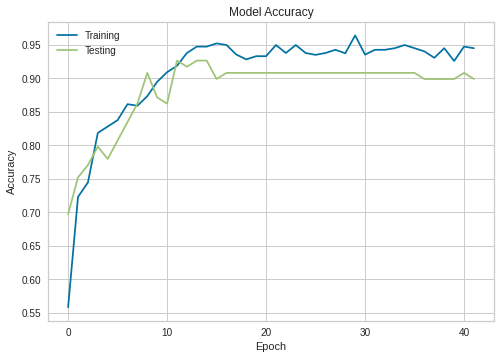

In [74]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()

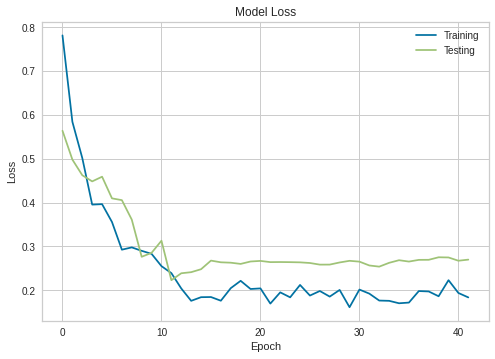

In [75]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()

In [76]:

y_pred = np.argmax(model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)
     

4/4 [==============================] - 3s 118ms/step
[1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0
 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0]
109
['CT_COVID' 'CT_NonCOVID']


In [77]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))
print(le.classes_)

[0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0
 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0]
109
['CT_COVID' 'CT_NonCOVID']


In [78]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[65  5]
 [ 3 36]]


,CT_COVID,CT_NonCOVID
CT_COVID,65,5
CT_NonCOVID,3,36


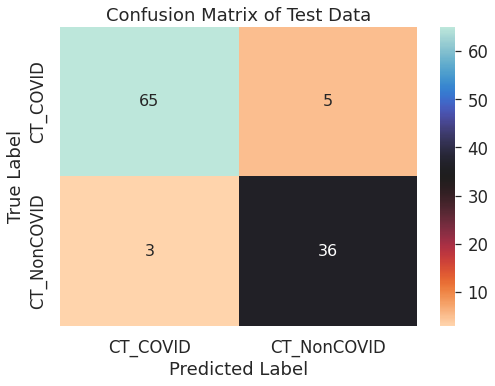

In [79]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='icefire_r')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Test Data')
plt.show()

In [41]:
from sklearn.metrics import classification_report

# Calculate classification report
report = classification_report(y_test_labels, y_pred, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

    CT_COVID       1.00      0.91      0.96        70
 CT_NonCOVID       0.87      1.00      0.93        39

    accuracy                           0.94       109
   macro avg       0.93      0.96      0.94       109
weighted avg       0.95      0.94      0.95       109



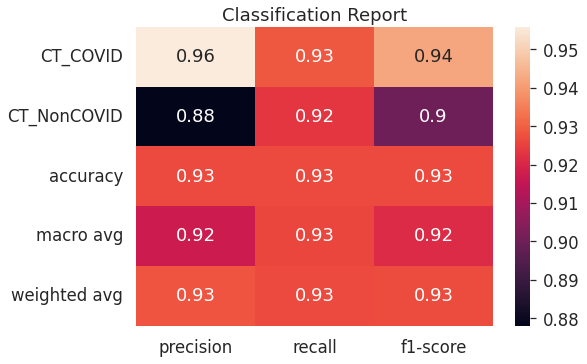

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score


report = classification_report(y_test_labels, y_pred, target_names=le.classes_)


report_dict = classification_report(y_test_labels, y_pred, target_names=le.classes_, output_dict=True)


sns.heatmap(pd.DataFrame(report_dict).iloc[:-1, :].T, annot=True)
plt.title('Classification Report')
plt.show()
